## **Лабораторная работа №2 по дисциплине "Технологии обеспечения информационной безопасности"**


---

Тема: Анализ логов


---

Выполнил: Асатрян Давид Робертоввич группа ББМО-01-23

---

Вариант №16: `15 mod 16 + 1 = 16`

Клонирование репозитория с логами для их последующего анализа

In [ ]:
import os.path

if not os.path.isdir("./loghub/"):
    !git clone https://github.com/logpai/loghub

## **Задание регулярного выражения для парсинга логов**

---


Пояснение к регулярному выражению:

Для примера возьмем строчку из логов Zookeeper:

`2015-07-29 19:14:07,653 - WARN  [SendWorker:188978561024:QuorumCnxManager$SendWorker@688] - Send worker leaving thread`

Регулярное выражение извлекает все поля записи лога и делит его на следующие группы:

---

1. (\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) соответствует дате и времени.

2. (\w+) - Эта часть ищет одно или более словенных символов (буквы, цифры или подчеркивания), которые представляют уровень лога (например, INFO, ERROR).

3. \[(.+)\] соответствует информации о потоке.

4. (.*) - Эта часть ищет любые символы (кроме новой строки), которые представляют сообщение лога.

In [ ]:
import re

log_entry = "2015-07-29 19:14:07,653 - WARN  [SendWorker:188978561024:QuorumCnxManager$SendWorker@688] - Send worker leaving thread"

regex_pattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) - (\w+) \[(.+)\] - (.*)'

matches = re.match(regex_pattern, log_entry)

if matches:
    date = matches.group(1)
    time = matches.group(2)
    log_level = matches.group(3)
    component = matches.group(4)
    message = matches.group(5)

    print("Date:", date)
    print("Time:", time)
    print("Log Level:", log_level)
    print("Component:", component)
    print("Message:", message)

## **Инициализация базы данных**

---
В среде выполнения создаётся каталог ./db, где будет храниться файл базы данных SQLite

In [ ]:
![ -d db ] || mkdir db

In [ ]:
import sqlite3

# Путь к файлу с БД
db_path = './db/log-analysis.db'

# Подключение к БД
connection = sqlite3.connect(db_path)
# Создание курсора
cursor = connection.cursor()

# Очистка БД, если таблица уже создана
cursor.execute("DROP TABLE IF EXISTS logs")
# Создание таблицы
cursor.execute("CREATE TABLE logs (id INTEGER PRIMARY KEY AUTOINCREMENT, datetime TEXT, msg_type TEXT, component TEXT, message TEXT)")

# Сохранение изменений
connection.commit()
# Закрытие курсора
cursor.close()
# Закрытие подключения к БД
connection.close()

## **Парсинг лога и сохранение записей в БД**

In [ ]:
import sqlite3
import re

# Подключение к БД и создание курсора
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

# Очистка таблицы для предотвращения дублирования данных
cursor.execute("DELETE FROM logs")

# Парсинг файла с логами
log_pattern = r'(\d{4}-\d{2}-\d{2})\s(\d{2}:\d{2}:\d{2},\d{3})\s+-\s+(\w+)\s+\[([^]]+)\]\s+-\s+(.*)'
with open('./loghub/Zookeeper/Zookeeper_2k.log', 'r', encoding='utf-8') as log_file:
    for line in log_file:
        log_match = re.match(log_pattern, line)
        if log_match:
            date = log_match.group(1)
            time = log_match.group(2)
            datetime = f"{date} {time}"  # Формирование полной даты в формате ISO8601
            msg_type = log_match.group(3)  # Уровень логирования
            component = log_match.group(4)
            message = log_match.group(5)
            values = (datetime, msg_type, component, message)  # Создание объекта для подстановки в SQL-запрос
            sql = "INSERT INTO logs (datetime, msg_type, component, message) VALUES (?, ?, ?, ?)"
            cursor.execute(sql, values)  # Запись данных в БД

connection.commit()
cursor.close()
connection.close()

## **Чтение записей из БД**

In [ ]:
import pandas as pd

# подключение к БД и создание курсора
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

# выборка всех записей из таблицы
cursor.execute("SELECT * FROM logs")
rows = cursor.fetchall()

cursor.close()
connection.close()

# запись данных в объект DataFrame
log_df = pd.DataFrame(rows, columns=("id", "Time", "Log level", "Component", "Message"))
log_df

,id,Time,Log level,Component,Message
0,1,"2015-07-29 19:04:12,394",INFO,/10.10.34.11:3888:QuorumCnxManager$Listener@493,Received connection request /10.10.34.11:45307
1,2,"2015-07-29 19:04:29,071",WARN,SendWorker:188978561024:QuorumCnxManager$SendW...,Send worker leaving thread
2,3,"2015-07-29 19:04:29,079",WARN,SendWorker:188978561024:QuorumCnxManager$SendW...,Interrupted while waiting for message on queue
3,4,"2015-07-29 19:13:17,524",WARN,SendWorker:188978561024:QuorumCnxManager$SendW...,Send worker leaving thread
4,5,"2015-07-29 19:13:24,282",WARN,RecvWorker:188978561024:QuorumCnxManager$RecvW...,"Connection broken for id 188978561024, my id =..."
...,...,...,...,...,...
1832,1833,"2015-08-10 17:52:39,698",INFO,NIOServerCxn.Factory:0.0.0.0/0.0.0.0:2181:ZooK...,Client attempting to establish new session at ...
1833,1834,"2015-08-10 17:53:14,914",INFO,NIOServerCxn.Factory:0.0.0.0/0.0.0.0:2181:NIOS...,Closed socket connection for client /10.10.34....
1834,1835,"2015-08-10 17:53:16,001",INFO,SessionTracker:ZooKeeperServer@325,"Expiring session 0x14f05578bd80006, timeout of..."
1835,1836,"2015-08-10 18:12:34,001",INFO,SessionTracker:ZooKeeperServer@325,"Expiring session 0x14f05578bd8000f, timeout of..."


## **Построение графика распределения уровней логирования**

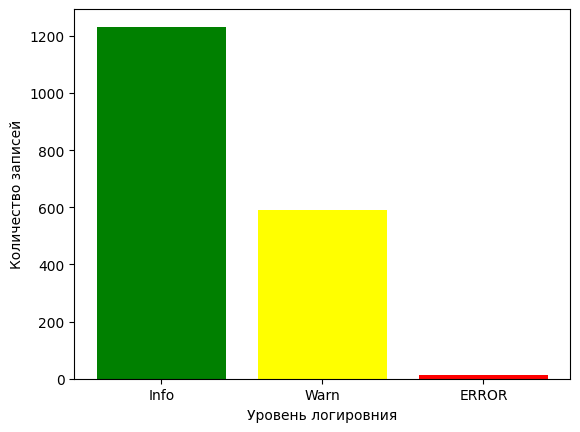

In [ ]:
import matplotlib.pyplot as plt

# подсчёт записей с различными уровнями логирования
log_level_distrib = log_df['Log level'].value_counts()

x = log_level_distrib.keys()
y = log_level_distrib.values

# более подробные заголовки для графика
verbose_xticks = ["Info", "Warn", "ERROR"]

plt.xticks([0,1,2], verbose_xticks)
plt.xticks(rotation=0)
plt.xlabel('Уровень логировния')
plt.ylabel('Количество записей')
plt.bar(x,y)
plt.bar(x,y, color = ['green', 'yellow', 'red'])

plt.show()

## **Построение графика распределения записей по компонентам, создавшим запись**

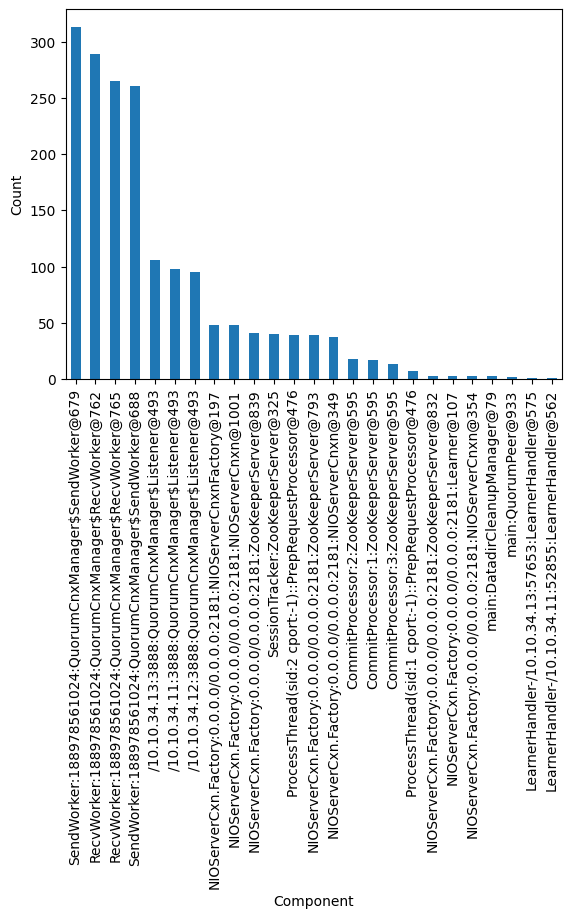

In [ ]:
# подсчёт записей с различными уровнями логирования
components_distrib = log_df['Component'].value_counts()[:25]

components_distrib.plot(kind='bar')

plt.xlabel('Component')
plt.ylabel('Count')
plt.show()

## **Построение графика распределения предупреждений за время логирования (сообщений с уровнем логирования 'W')**

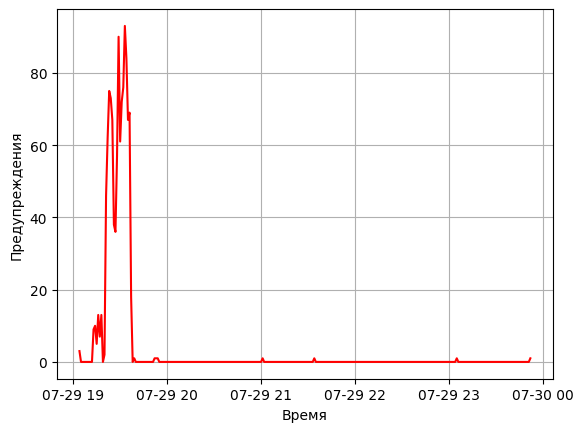

In [ ]:
warning_df = log_df[(log_df['Log level'] == 'WARN') & (log_df['Time'].str.startswith('2015-07-29'))].copy()

# Конвертация времени в объект datetime с учетом формата
warning_df['Time'] = pd.to_datetime(warning_df['Time'], format='%Y-%m-%d %H:%M:%S,%f')

# Группировка по времени
warning_count = warning_df.groupby('Time').size()

# Ресэмплинг для группировки по целым секундам для наглядности
warning_count = warning_count.resample('T').sum()
warning_count = warning_count.fillna(0)

# Построение графика
plt.plot(warning_count.index, warning_count.values, linestyle='-', color='r')
plt.xlabel('Время')
plt.ylabel('Предупреждения')
plt.grid(True)
plt.show()